In [1]:
import sys
sys.path.append('../')
import argparse
from dataset.get_dataset import getDataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

class args_struct:
    def __init__(self):
        self.dataroot = '../../data/DiscRegion/DiscRegion'
        self.rater_num = 6
        self.img_width = 256
        self.img_height = 256
        self.dataset = 'RIGA'
        self.validate = True
        self.standardize = False
        self.random_seed = 27
args = args_struct()
train_set, valid_set, test_set = getDataset(args, validate=args.validate)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def get_dice_threshold(output, mask, threshold):
    """
    :param output: output shape per image, float, (0,1)
    :param mask: mask shape per image, float, (0,1)
    :param threshold: the threshold to binarize output and feature (0,1)
    :return: dice of threshold t
    """
    smooth = 1e-6

    zero = torch.zeros_like(output)
    one = torch.ones_like(output)
    output = torch.where(output > threshold, one, zero)
    mask = torch.where(mask > threshold, one, zero)
    output = output.view(-1)
    mask = mask.view(-1)
    intersection = (output * mask).sum()
    dice = (2. * intersection + smooth) / (output.sum() + mask.sum() + smooth)

    return dice
def get_soft_dice(outputs, masks):
    """
    :param outputs: B * output shape per image
    :param masks: B * mask shape per image
    :return: average dice of B items
    """
    dice_list = []
    for this_item in range(outputs.size(0)):
        output = outputs[this_item]
        mask = masks[this_item]
        dice_item_thres_list = []
        for thres in [0.1, 0.3, 0.5, 0.7, 0.9]:
            dice_item_thres = get_dice_threshold(output, mask, thres)
            dice_item_thres_list.append(dice_item_thres.data)
        dice_item_thres_mean = np.mean(dice_item_thres_list)
        dice_list.append(dice_item_thres_mean)

    return np.mean(dice_list)

#### Get model preds

In [4]:
from models.unet_le import UNetLE

In [5]:
class args_struct:
    def __init__(self):
        self.dataroot = '../../data/DiscRegion/DiscRegion'
        self.rater_num = 6
        self.img_width = 256
        self.img_height = 256
        self.dataset = 'RIGA'
        self.validate = True
        self.standardize = True
        self.random_seed = 27
        self.loss_func = 'bce'
        self.batch_size = 1
        self.gt_type_train = -1
        self.num_worker = 4

In [6]:
args = args_struct()

args.gt_type_train = -1
args.loss_func = 'bce' 
args.batch_size = 1
args.num_worker = 4
args.use_mix_label = False
args.standardize = True

In [7]:
from trainer.train_riga_unet_le import validate_riga_le
from loss_func.get_loss import get_loss_func

loss_func = get_loss_func(args)

In [8]:
import albumentations as A

In [145]:
transforms = None

transforms_50 = A.Compose([
    A.GaussNoise(p=0.5, var_limit=(50, 60)),
    A.Blur(p=0.5, blur_limit=21),
    A.HueSaturationValue(p=0.5, hue_shift_limit=(50, 60))
], p=1)

transforms_100 = A.Compose([
    A.GaussNoise(p=1, var_limit=(50, 60)),
    A.Blur(p=1, blur_limit=21),
    A.HueSaturationValue(p=1, hue_shift_limit=(50, 60))
], p=1)

In [146]:
args = args_struct()
train_set, valid_set, test_set = getDataset(args, validate=args.validate, transforms=None)

_, _, test_set_50 = getDataset(args, validate=args.validate, transforms=transforms_50)

_, _, test_set_100 = getDataset(args, validate=args.validate, transforms=transforms_100)

In [21]:
models = {
    # 'le': {
    #     'path': '/media/kudaibergen/TS512/projects_ts/grader_soup/src/outputs/RIGA_gt_annots_train_majority_vote_UnetLE_bce_pretrain0_validateTrue/bs16_lr5e-05_wd0.0_epoch200/loop0/checkpoints/best_loss.pt'
    # },
    'our': {
        'path': '/media/kudaibergen/TS512/projects_ts/grader_soup/src/outputs/RIGA_gt_annots_train_majority_vote_UnetLE_LE_w0.3_decoder_heads_only_var_5_lbls_bce_pretrain0_validateTrue/bs16_lr5e-05_wd0.0_epoch200/loop0/checkpoints/best_loss.pt'
    }} 

for key, value in models.items():
    skip_encoder = False if key == 'le' else True
    model = UNetLE(skip_encoder=skip_encoder)
    model.load_state_dict(torch.load(value['path'])['model'])
    models[key]['model'] = model        

cup_idx = 1
disc_idx = 0

In [164]:
def get_model_outputs(args, model, val_set, loss_function, skip_idx=None):
    model = model.cuda()
    val_loader = DataLoader(val_set, batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker, pin_memory=True)

    model.eval()

    outputs_model = []
    masks = []
    disc_dices = []
    cup_dices = []

    for step, data in enumerate(val_loader):
        with torch.no_grad():
            imgs = data['image'].cuda()
            mask = data['mask']

            outputs = model({'image': imgs})

            mask_major_vote = torch.stack(mask, dim=0).sum(dim=0) / args.rater_num
            gt_mask = mask_major_vote.cuda()

            outputs_sigmoid = []
            disc_dices_img = []
            cup_dices_img = []
            if skip_idx is not None:
                outputs = outputs[skip_idx:]

            for i, out in enumerate(outputs):
                out = torch.nn.functional.interpolate(out, size=mask[0].shape[2:])
                out = torch.sigmoid(out)
                outputs_sigmoid.append(out)

            # for i in range(len(outputs_sigmoid) - 1):
            #     val_soft_dice_disc = get_soft_dice(
            #         outputs=outputs_sigmoid[i][:, 0, :, :].cpu(),
            #         masks=outputs_sigmoid[i+1][:, 0, :, :].cpu()) * imgs.size(0)
            #     val_soft_dice_cup = get_soft_dice(
            #         outputs=outputs_sigmoid[i][:, 1, :, :].cpu(), 
            #         masks=outputs_sigmoid[i+1][:, 1, :, :].cpu()) * imgs.size(0)
            #     disc_dices_img.append(val_soft_dice_disc)
            #     cup_dices_img.append(val_soft_dice_cup)
            
            temp_disc = []
            temp_cup = []
            for i in range(len(outputs_sigmoid)):
                for j in range(i+1, len(outputs_sigmoid)):        
                    val_soft_dice_disc = get_soft_dice(
                        outputs=outputs_sigmoid[i][:, 0, :, :].cpu(),
                        masks=outputs_sigmoid[j][:, 0, :, :].cpu()) * imgs.size(0)
                    val_soft_dice_cup = get_soft_dice(
                        outputs=outputs_sigmoid[i][:, 1, :, :].cpu(), 
                        masks=outputs_sigmoid[j][:, 1, :, :].cpu()) * imgs.size(0)
                    temp_disc.append(val_soft_dice_disc)
                    temp_cup.append(val_soft_dice_cup)

            disc_dices_img.append(temp_disc)
            cup_dices_img.append(temp_cup)


        disc_dices.append(disc_dices_img)
        cup_dices.append(cup_dices_img)
    return disc_dices, cup_dices

In [159]:
disc_threshold = 0.9
cup_threshold = 0.85

In [165]:
for key, val in models.items():
    skip_idx = None if key == 'le' else None
    disc_dices, cup_dices = get_model_outputs(args, val['model'], test_set, loss_func, skip_idx=skip_idx)
    models[key]['dices'] = (disc_dices, cup_dices)

    disc_dices_50, cup_dices_50 = get_model_outputs(args, val['model'], test_set_50, loss_func, skip_idx=skip_idx)
    models[key]['dices_50'] = (disc_dices_50, cup_dices_50)

    disc_dices_100, cup_dices_100 = get_model_outputs(args, val['model'], test_set_100, loss_func, skip_idx=skip_idx)
    models[key]['dices_100'] = (disc_dices_100, cup_dices_100)

In [178]:
# def get_prediction_depths(dice_agreements, dice_th):
#     result = []
#     for agreements in dice_agreements:
#         agreement = 0
#         for i, val in enumerate(agreements):
#             if val < dice_th:
#                 agreement = i + 1
#         result.append(agreement)
#     return result

# def get_prediction_depths(dice_agreements, dice_th):
#     result = []
#     for agreements in dice_agreements:
#         for i, val in enumerate(agreements):
#             if val >= dice_th:
#                 result.append(1)
#             else:
#                 result.append(0)
#     return result

def get_prediction_depths(dice_agreements, dice_th):
    result = []
    for agreements in dice_agreements:
        # print(agreements)
        result.append(np.var(agreements))
    return result

In [201]:
for key, val in models.items():
    for dice_postfix in ['', '_50', '_100']:
        pd_disc = get_prediction_depths(val[f'dices{dice_postfix}'][0], disc_threshold)
        models[key][f'pd_disc{dice_postfix}'] = pd_disc

        pd_cup = get_prediction_depths(val[f'dices{dice_postfix}'][1], cup_threshold)
        models[key][f'pd_cup{dice_postfix}'] = pd_cup

In [1]:
sns.kdeplot(models[key][f'pd_disc'], label='0% distortion')
sns.kdeplot(models[key][f'pd_disc_50'], label='50% distortion')
sns.kdeplot(models[key][f'pd_disc_100'], label='100% distortion')
plt.xlabel('Agreement Variance')
plt.legend()

NameError: name 'sns' is not defined

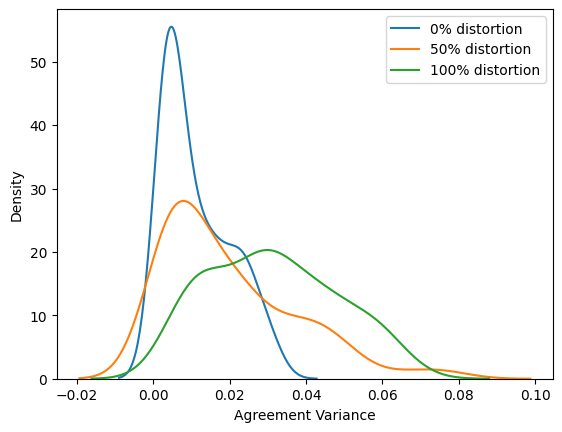

In [216]:
sns.kdeplot(models[key][f'pd_cup'], label='0% distortion')
sns.kdeplot(models[key][f'pd_cup_50'], label='50% distortion')
sns.kdeplot(models[key][f'pd_cup_100'], label='100% distortion')
plt.xlabel('Agreement Variance')
plt.legend()

In [133]:
struct = 'cup'

<BarContainer object of 10 artists>

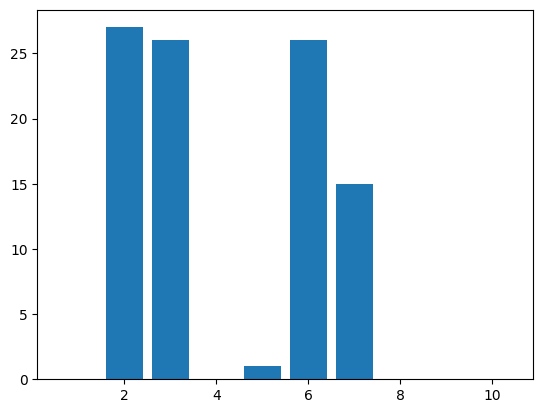

In [20]:
max_pd = 10
key = 'le'

x = [i+1 for i in range(max_pd)]
counts = [models[key][f'pd_{struct}'].count(value) for value in x]

plt.bar(x, counts)